# I’m Something of a Painter Myself: Use GANs to create art - will you be the next Monet?

Welcome to this Jupyter Notebook on Generative Adversarial Networks (GANs) and their application in generating Monet-style images. In this notebook, we will explore the use of GANs for mimicking the unique painting style of the famous Impressionist artist, Claude Monet.

As we know, every artist has their own unique style, which is reflected in their work through features such as color choices, brush strokes, and composition. The idea behind GANs is to use deep learning algorithms to generate images that mimic the style of a particular artist.

In this notebook, we will create a GAN that consists of a generator model and a discriminator model. The generator model will generate Monet-style images, while the discriminator model will classify the images as real or generated. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

By the end of this notebook, we aim to generate 7,000 to 10,000 high-quality Monet-style images that can fool the discriminator model into believing they are real Monet paintings.

Let's get started!

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import re

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

# set seed for experiment reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
#!ls ~/datasets/gan-getting-started/monet_tfrec

In [3]:
root_dir = os.path.expanduser('/kaggle/input/gan-getting-started')
monet_files = tf.io.gfile.glob(str(f'{root_dir}/monet_tfrec/monet*.tfrec'))
photo_files = tf.io.gfile.glob(str(f'{root_dir}/photo_tfrec/photo*.tfrec'))

len(monet_files), len(photo_files)

(5, 20)

In [4]:
# get the number of examples in each dataset
n_monet_samples = sum(
    int(re.compile(r"-([0-9]*)\.").search(filename)[1]) for filename in monet_files
)
n_photo_samples = sum(
    int(re.compile(r"-([0-9]*)\.").search(filename)[1]) for filename in photo_files
)
n_monet_samples, n_photo_samples

(300, 7038)

In [5]:
batch_size = 1
orig_img_size = (256, 256)
input_img_size = (256, 256, 3)
buffer_size = 256


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


def read_tfrecord(item):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    item = tf.io.parse_single_example(item, features)
    image = tf.image.decode_jpeg(item['image'], channels=3)
    image = tf.cast(image, tf.float32)
    # normalize the pixel values to [-1, 1]
    image = (image / 127.5) - 1
    return tf.reshape(image, [256, 256, 3])


def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=autotune)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset


monet_ds = load_dataset(monet_files)
photo_ds = load_dataset(photo_files)

2023-02-13 06:09:25.253471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 06:09:25.364721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 06:09:25.365627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 06:09:25.380558: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
# split the dataset into train and test

train_size = 0.7
monet_train_size = int(n_monet_samples * train_size)
monet_test_size = n_monet_samples - monet_train_size
photo_train_size = int(n_photo_samples * train_size)
photo_test_size = n_photo_samples - photo_train_size

batch_size = 1

monet_ds = monet_ds.shuffle(1000)
photo_ds = photo_ds.shuffle(1000)

monet_train = monet_ds.take(monet_train_size).batch(batch_size)
monet_test = monet_ds.skip(monet_train_size).take(monet_test_size).batch(batch_size)

photo_train = photo_ds.take(photo_train_size).batch(batch_size)
photo_test = photo_ds.skip(photo_train_size).take(photo_test_size).batch(batch_size)

2023-02-13 06:09:28.375161: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


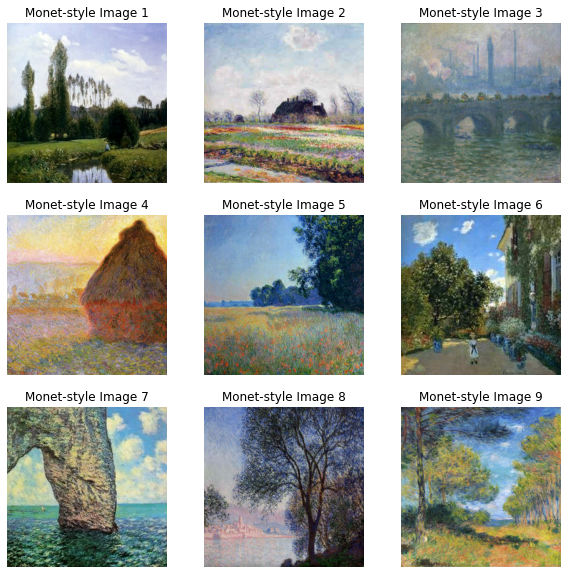

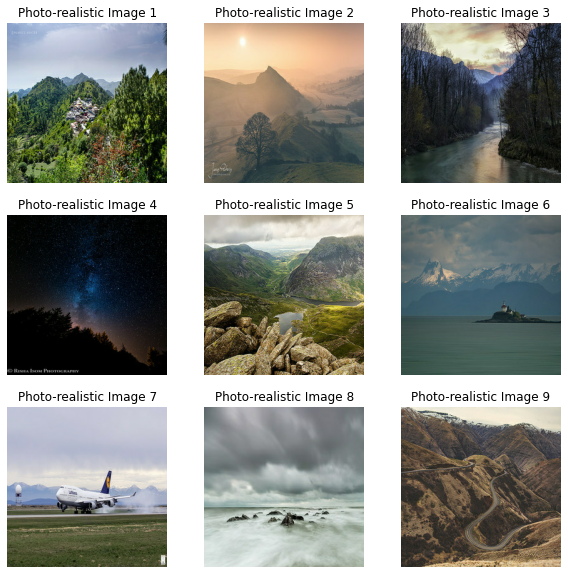

In [7]:
# visualize the dataset

# import matplotlib.pyplot as plt

# Visualize Monet-style images
plt.figure(figsize=(10, 10))
for i, img in enumerate(monet_train.take(9)):
    img = tf.squeeze(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((img + 1) / 2)
    plt.title(f'Monet-style Image {i + 1}')
    plt.axis("off")

# Visualize photo-realistic images
plt.figure(figsize=(10, 10))
for i, img in enumerate(photo_train.take(9)):
    img = tf.squeeze(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((img + 1) / 2)
    plt.title(f'Photo-realistic Image {i + 1}')
    plt.axis("off")

## Building blocks for CycleGAN 

The CycleGAN model consists of two generators and two discriminators. The generators are responsible for converting images from one domain to another, while the discriminators are responsible for classifying images as real or fake.




In [8]:
# reflection padding layer for the generator. reference: https://keras.io/examples/generative/cyclegan/#building-blocks-used-in-the-cyclegan-generators-and-discriminators


class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

In [9]:
# residual block for the generator

kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)
gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=42)


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='valid',
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = tf.keras.layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = tf.keras.layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = tf.keras.layers.Add()([input_tensor, x])
    return x

In [10]:
def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding='same',
    gamma_initializer=gamma_init,
):
    x = tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)

    return x


def upsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding='same',
    gamma_initializer=gamma_init,
):
    x = tf.keras.layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)

    if activation:
        x = activation(x)

    return x

## Building the generators 

The generator model is responsible for converting images from one domain to another. The generator model consists of a series of convolutional and transposed convolutional layers, with batch normalization and ReLU activation functions. The generator model takes an image as input and outputs a transformed image.

In [11]:
# generator model


def resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = tf.keras.layers.Input(shape=[256, 256, 3], name=f'{name}_img_input')

    x = ReflectionPadding2D((3, 3))(img_input)
    x = tf.keras.layers.Conv2D(filters, (7, 7), padding='valid', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(
            x,
            filters=filters,
            activation=tf.keras.layers.Activation('relu'),
            gamma_initializer=gamma_initializer,
        )

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(
            x, activation=tf.keras.layers.Activation('relu'), gamma_initializer=gamma_initializer
        )

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(
            x,
            filters=filters,
            activation=tf.keras.layers.Activation('relu'),
            gamma_initializer=gamma_initializer,
        )

    x = ReflectionPadding2D((3, 3))(x)
    x = tf.keras.layers.Conv2D(3, (7, 7), padding='valid')(x)
    x = tf.keras.layers.Activation('tanh')(x)

    return tf.keras.models.Model(img_input, x, name=name)

## Discriminator model

The discriminator model is responsible for classifying images as real or fake. The discriminator model consists of a series of convolutional layers, with batch normalization and LeakyReLU activation functions. The discriminator model takes an image as input and outputs a single value that indicates whether the image is real or fake.

In [12]:
# discriminator model


def discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None):
    img_input = tf.keras.layers.Input(shape=[256, 256, 3], name=f'{name}_img_input')

    x = img_input

    x = tf.keras.layers.Conv2D(
        filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer
    )(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        strides = (1, 1) if num_downsample_block < 2 else (2, 2)
        x = tf.keras.layers.Conv2D(
            num_filters,
            (4, 4),
            strides=strides,
            padding='same',
            kernel_initializer=kernel_initializer,
            use_bias=False,
        )(x)
        x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding='same', kernel_initializer=kernel_initializer
    )(x)

    return tf.keras.models.Model(img_input, x, name=name)

In [13]:
# Get the generators

gen_G = resnet_generator(name='gen_G')
gen_F = resnet_generator(name='gen_F')

# Get the discriminators

disc_X = discriminator(name='disc_X')
disc_Y = discriminator(name='disc_Y')

In [14]:
# build cyclegan model


class CycleGan(tf.keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn

        self.cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is photo and y is monet
        real_x, real_y = batch_data

        # For cycle gan, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        # 1. Pass real images through the generators to get the generated images
        # 2. Pass the generated images to the corresponding discriminators
        #    to get the generated loss
        # 3. Calculate the generator loss
        # 4. Calculate the gradients and apply it to the optimizer
        # 5. Calculte the generators total loss (fake loss + cycle loss + identity loss)
        # 6. Calculate the discriminator loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y
            # Generator F translates Y -> X.

            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            # Cycle
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_real_y = self.disc_Y(real_y, training=True)

            disc_fake_x = self.disc_X(fake_x, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y) * self.lambda_cycle * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x) * self.lambda_cycle * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Calculate the gradients for generator and discriminator
        generator_G_gradients = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        generator_F_gradients = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        discriminator_X_gradients = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        discriminator_Y_gradients = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Apply the gradients to the optimizer
        self.gen_G_optimizer.apply_gradients(
            zip(generator_G_gradients, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(generator_F_gradients, self.gen_F.trainable_variables)
        )

        self.disc_X_optimizer.apply_gradients(
            zip(discriminator_X_gradients, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(discriminator_Y_gradients, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [15]:
# create callback for saving images


class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_train.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
        plt.show()
        plt.close()

In [16]:
# Train the end-to-end model

# loss function for evaluating adversarial loss
adv_loss_fn = tf.keras.losses.MeanSquaredError()


# Define the loss function for the generators
def generator_loss_fn(fake):
    return adv_loss_fn(tf.ones_like(fake), fake)


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) / 2

In [17]:
# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G,
    generator_F=gen_F,
    discriminator_X=disc_X,
    discriminator_Y=disc_Y,
)

In [18]:
# compile the model

cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [19]:
# Callback for saving images
plotter = GANMonitor()

checkpoint_path = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)

Epoch 1/2


2023-02-13 06:10:34.187026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


210/210 [==============================] - 159s 447ms/step - G_loss: 5.1816 - F_loss: 5.7105 - D_X_loss: 0.1148 - D_Y_loss: 0.1098


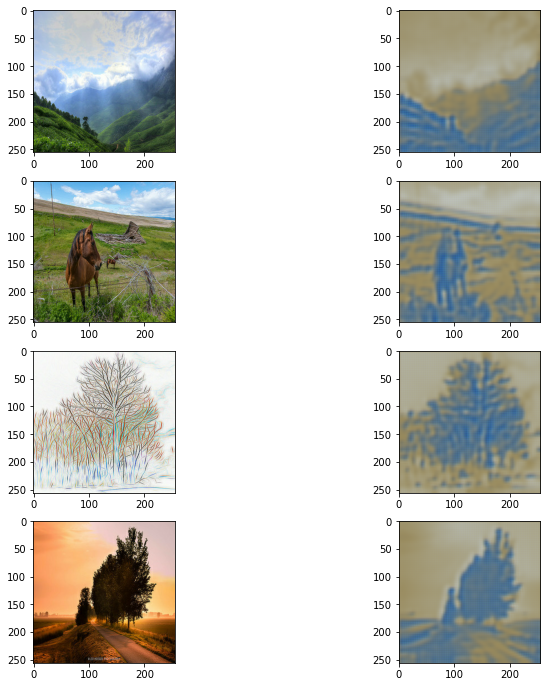

Epoch 2/2
210/210 [==============================] - 95s 447ms/step - G_loss: 4.8489 - F_loss: 5.0338 - D_X_loss: 0.0568 - D_Y_loss: 0.1579


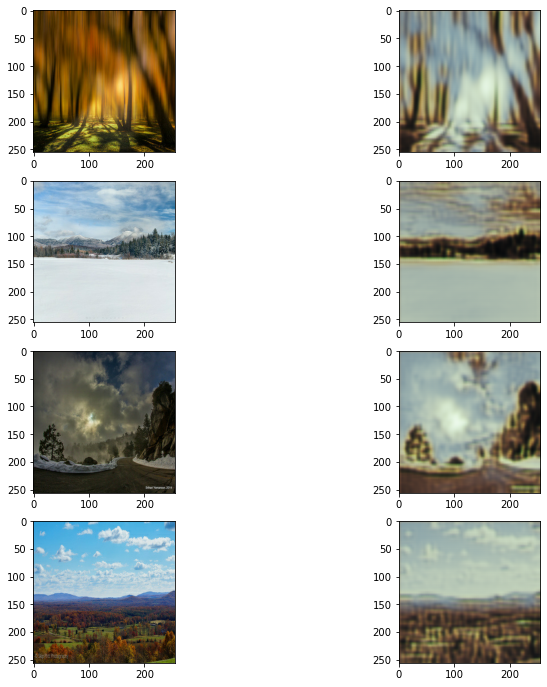

In [20]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train, monet_train)),
    epochs=2,
    callbacks=[plotter],
)

In [21]:
import PIL

!mkdir -p /kaggle/images

In [22]:
index = 0

for index, img in enumerate(photo_ds.batch(1)):
    prediction = gen_G(img, training=False).numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    for pred in prediction:
        im = PIL.Image.fromarray(pred)
        im.save(f"/kaggle/images/{index}.jpg")
        index += 1

        if index > 8000:
            break

print(index)

7038


In [23]:
import shutil

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'